In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from itertools import product
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import joblib  # 모델 저장을 위한 라이브러리

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [4]:
def calculate_metrics(y_true, y_pred, training_time):
	"""평가 지표 계산 함수"""
	return {
		'MAE': mean_absolute_error(y_true, y_pred),
		'MSE': mean_squared_error(y_true, y_pred),
		'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
		'R2': r2_score(y_true, y_pred),
		'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
		'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
		'Training_Time': training_time
	}

### 광어 

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [260],
		'max_depth': [8],
		'learning_rate': [0.1],
		'num_leaves': [9],
		'min_child_samples': [ 7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

In [35]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [260],
		'max_depth': [8],
		'learning_rate': [0.1],
		'num_leaves': [9],
		'min_child_samples': [ 7],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//10
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	plt.figure(figsize=(15, 7))
	plt.plot(data['date'], y, label='Actual', color='blue')
	plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	plt.title('Actual vs Predicted Price')
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.legend()
	plt.grid(True)
	plt.xticks(rotation=45)
	plt.tight_layout()
	plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# 그래프 생성
			plt.figure(figsize=(15, 7))
			plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			plt.title(f'Actual vs Predicted Price ({col})')
			plt.xlabel('Date')
			plt.ylabel('Price')
			plt.legend()
			plt.grid(True)
			plt.xticks(rotation=45)								
			plt.tight_layout()
			plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4772
[LightGBM] [Info] Number of data points in the train set: 26261, number of used features: 21
[LightGBM] [Info] Start training from score 35918.308899
2.3499534130096436

** Model Performance **
Best RMSE: 1133.3588

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 8
min_child_samples: 7
n_estimators: 260
n_jobs: -1
num_leaves: 9
random_state: 1030
subsample: 0.9


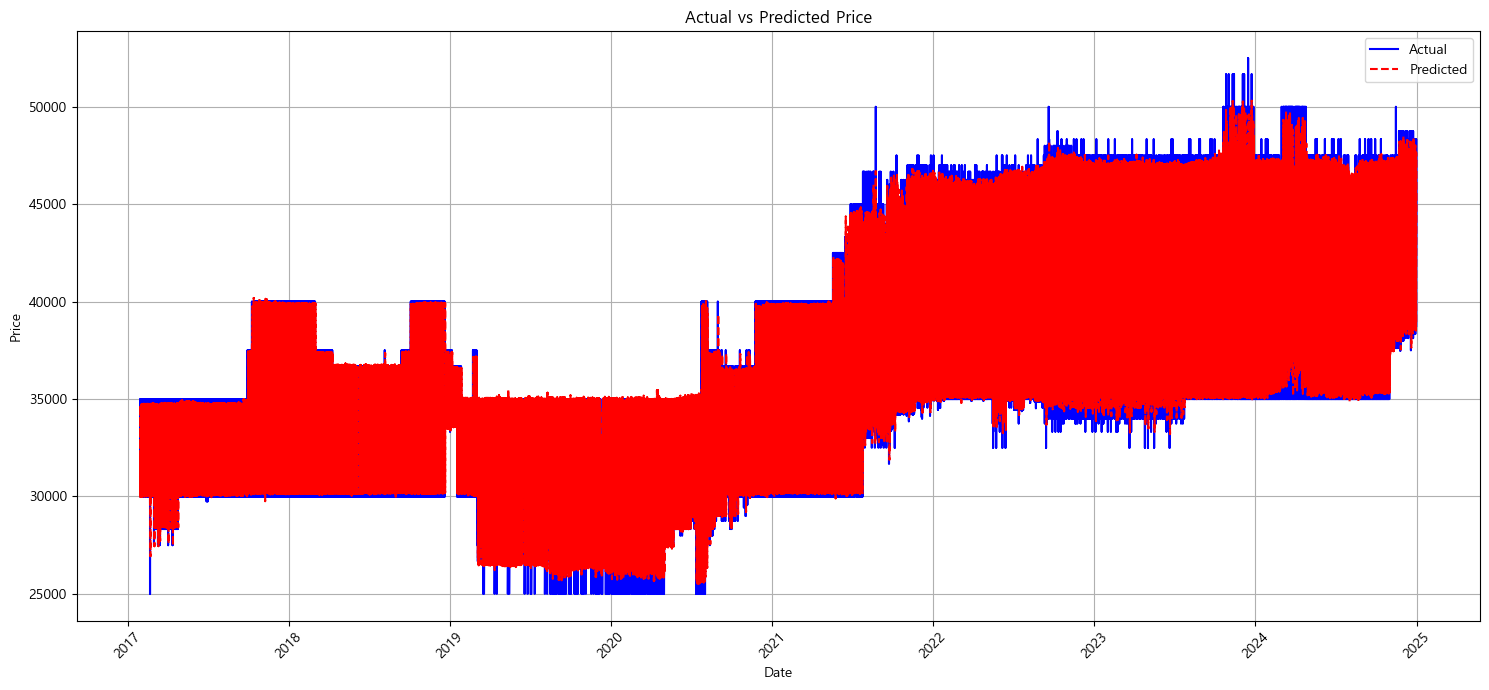

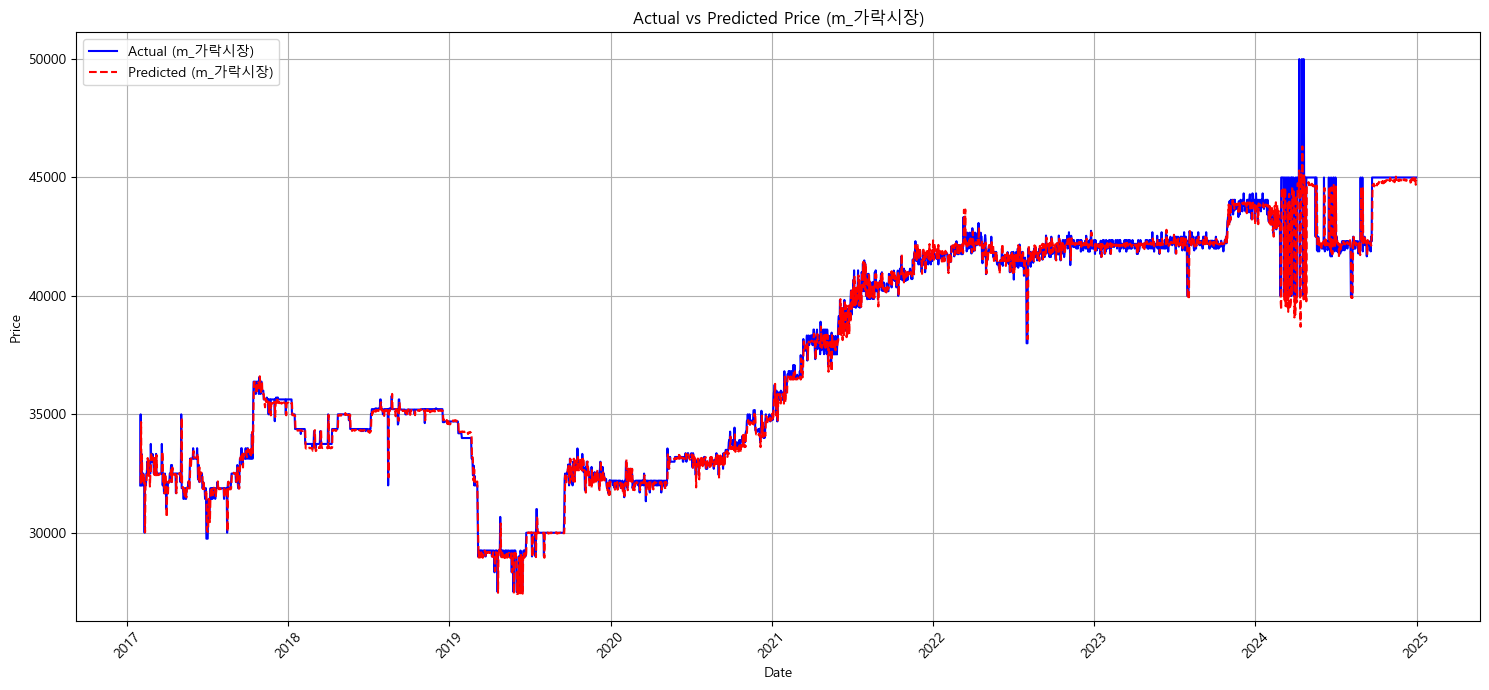

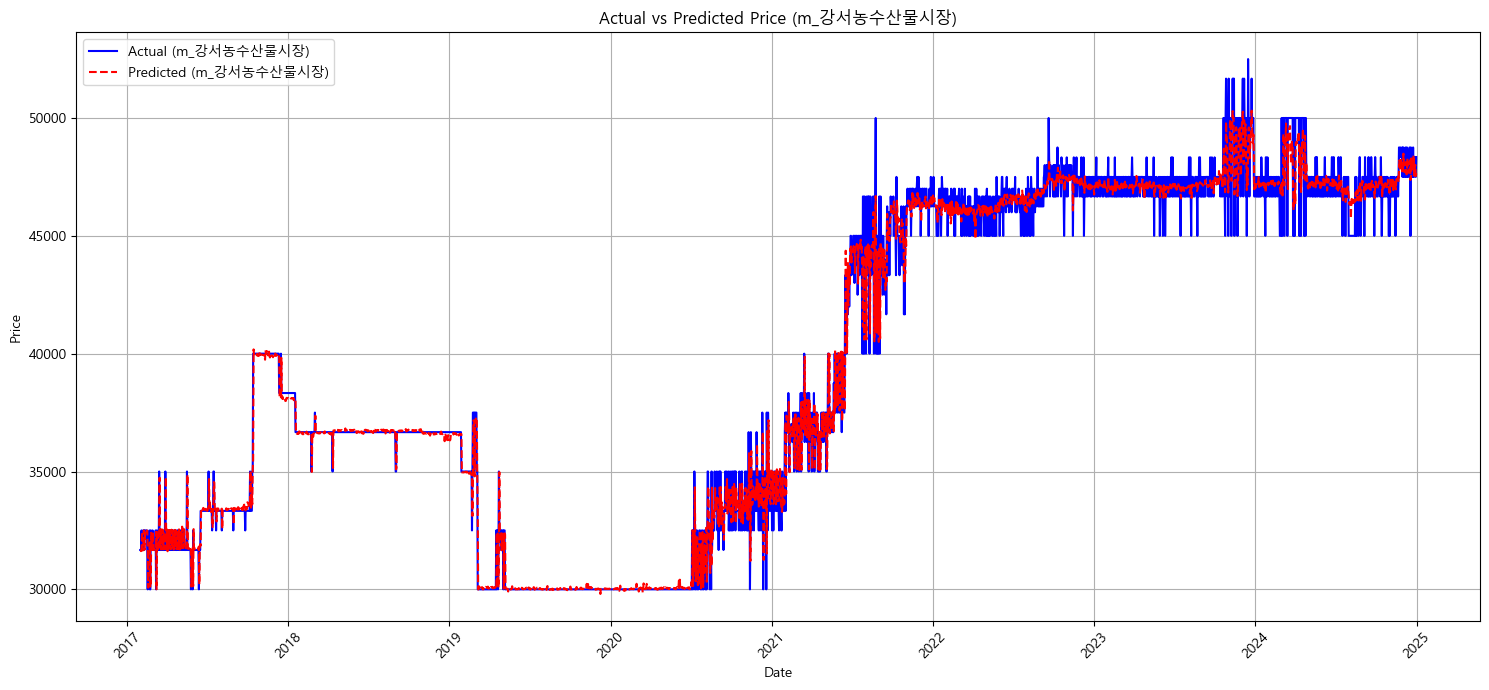

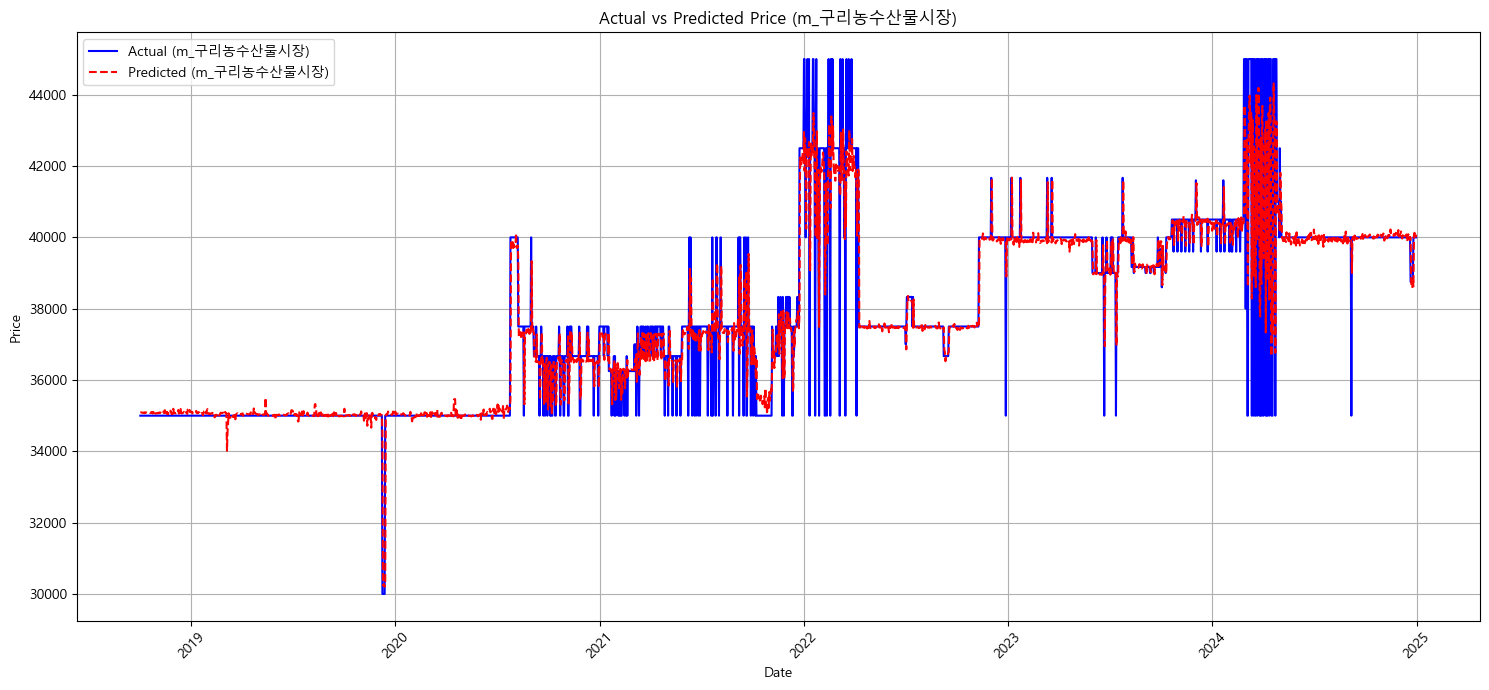

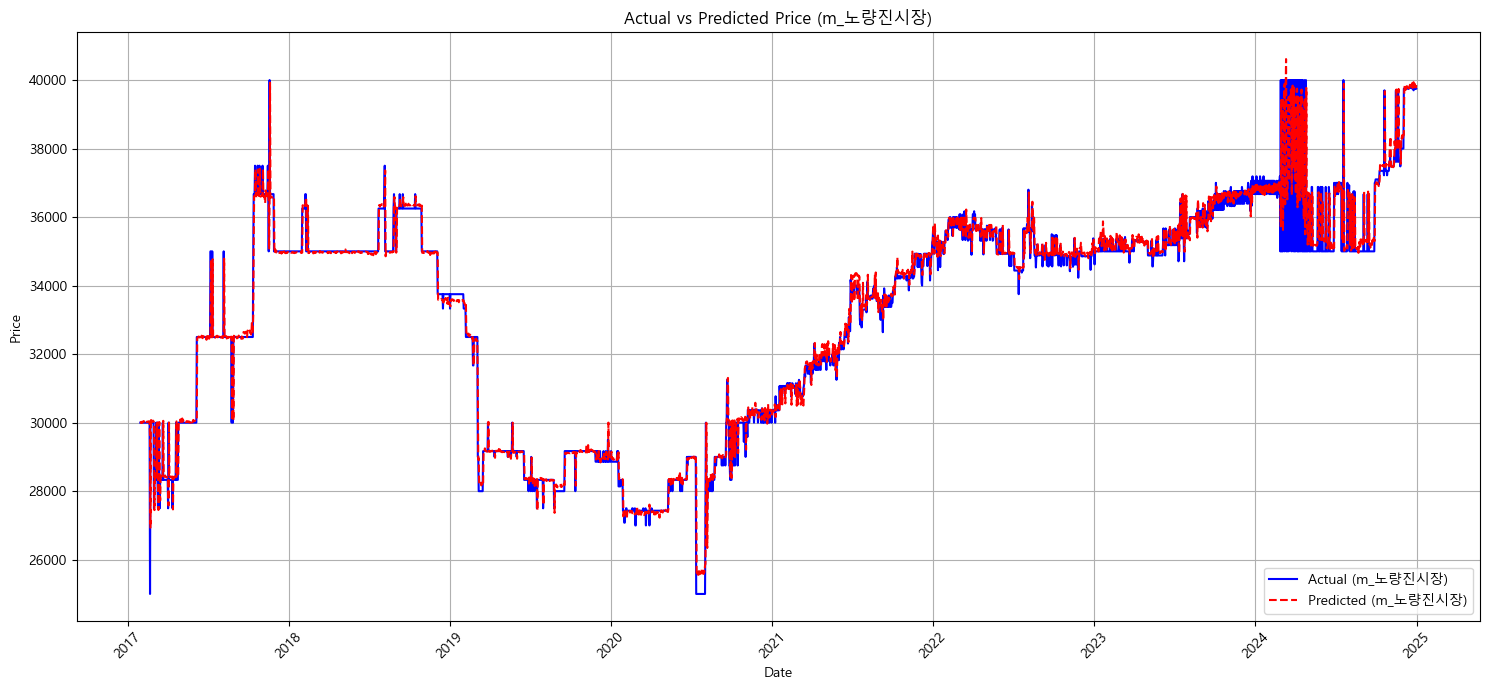

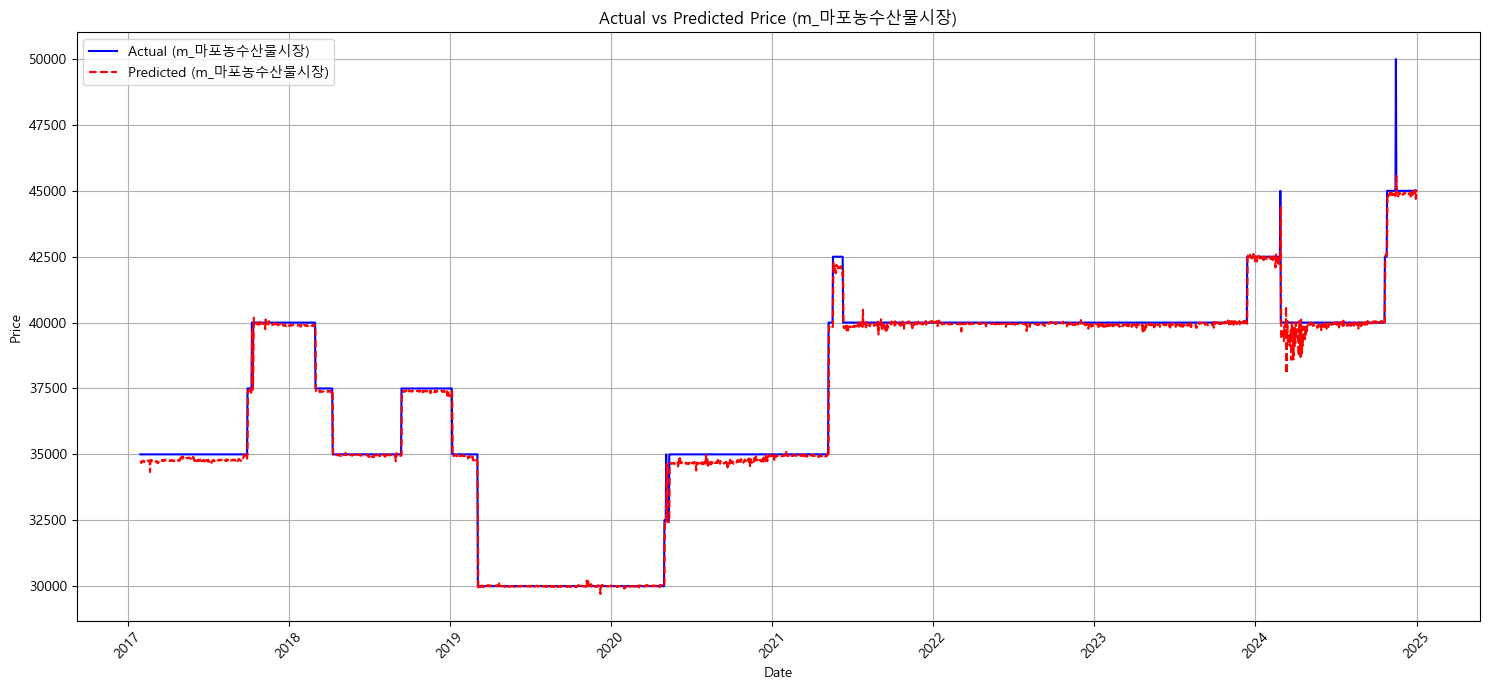

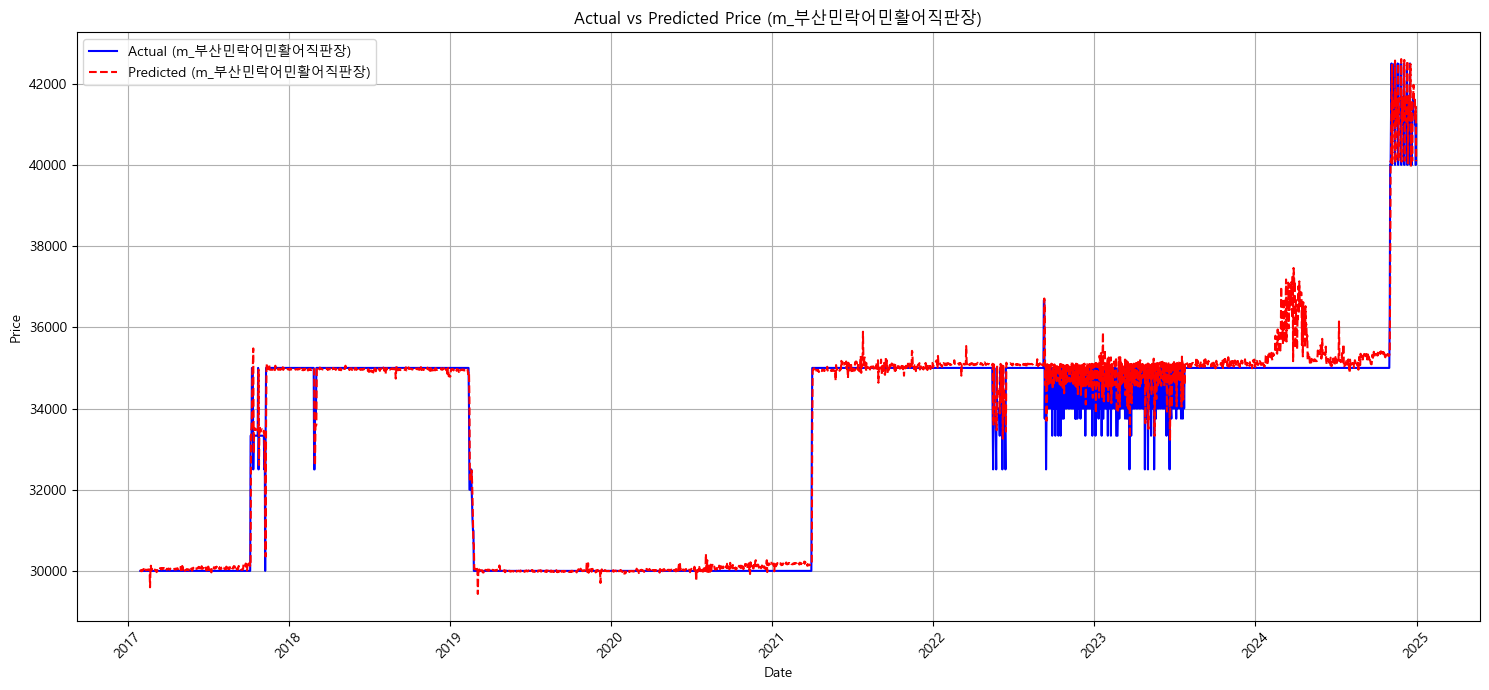

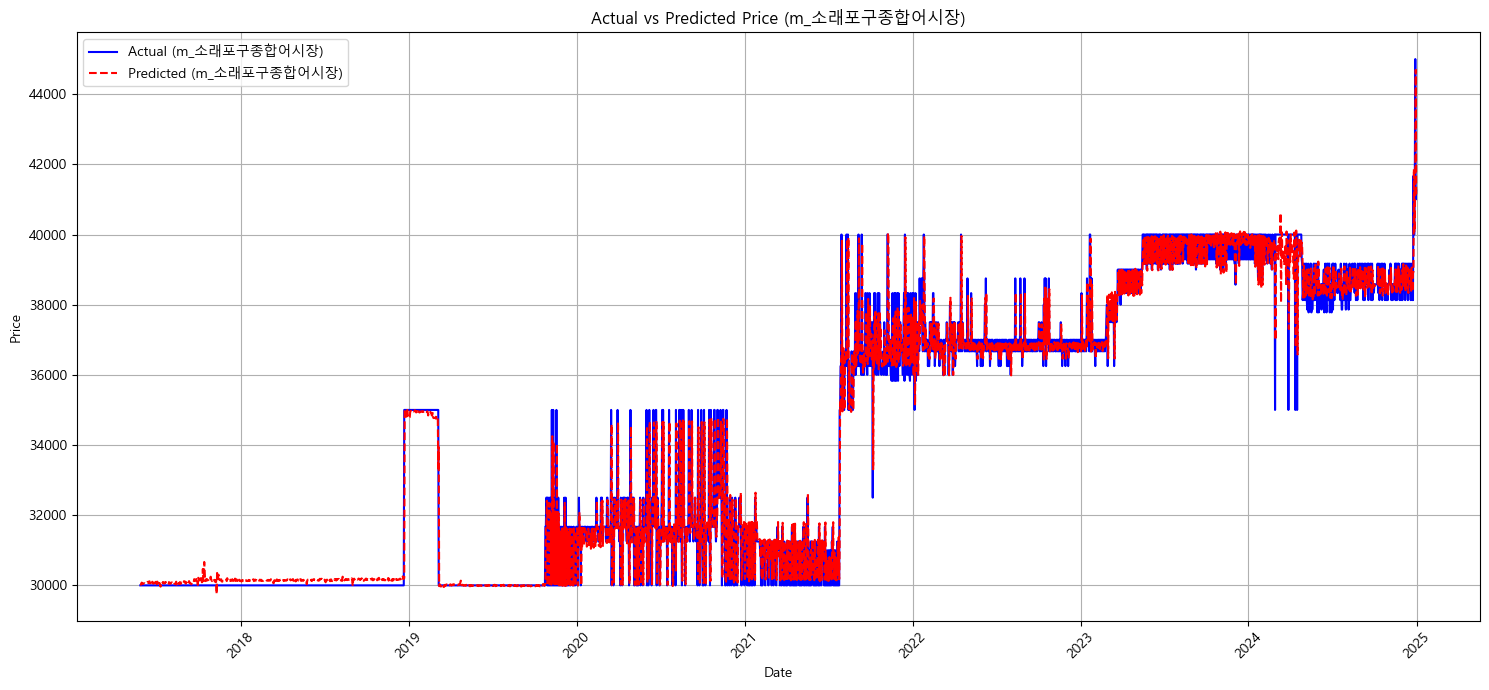

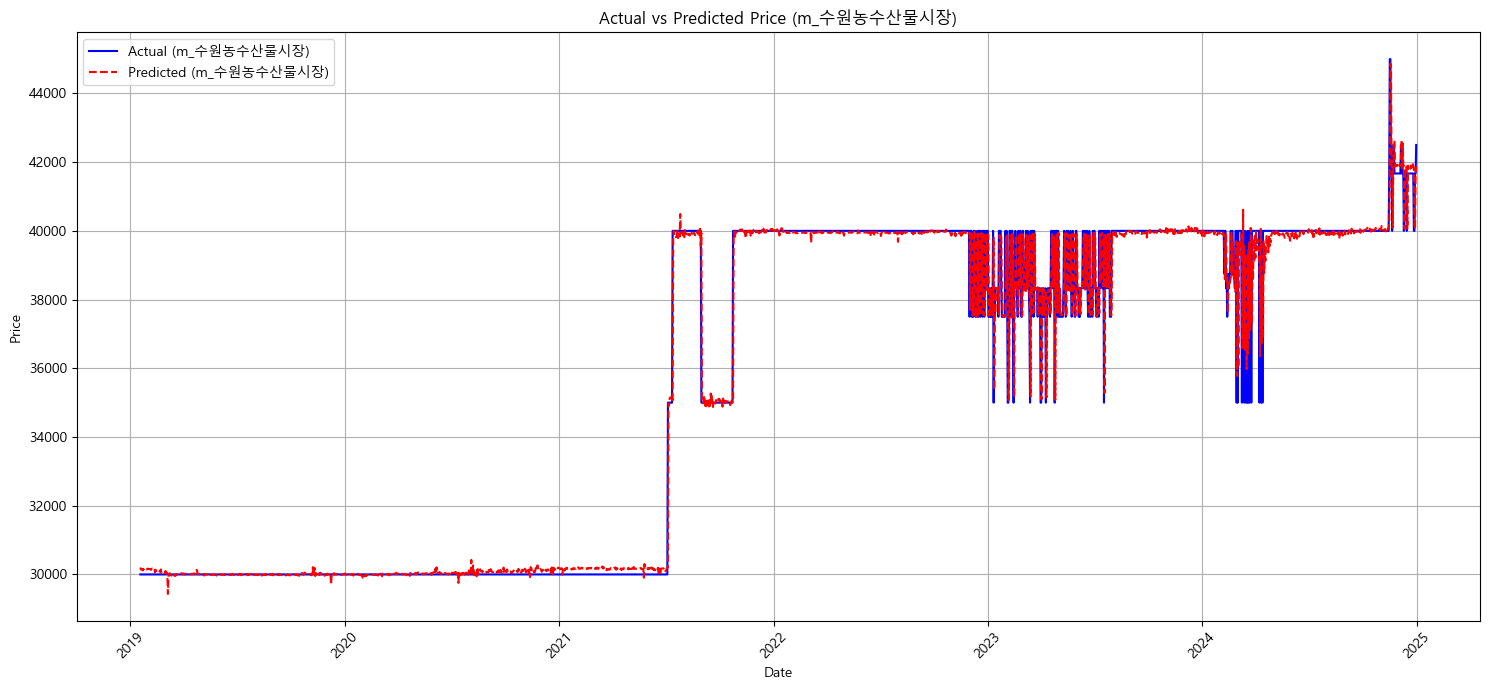

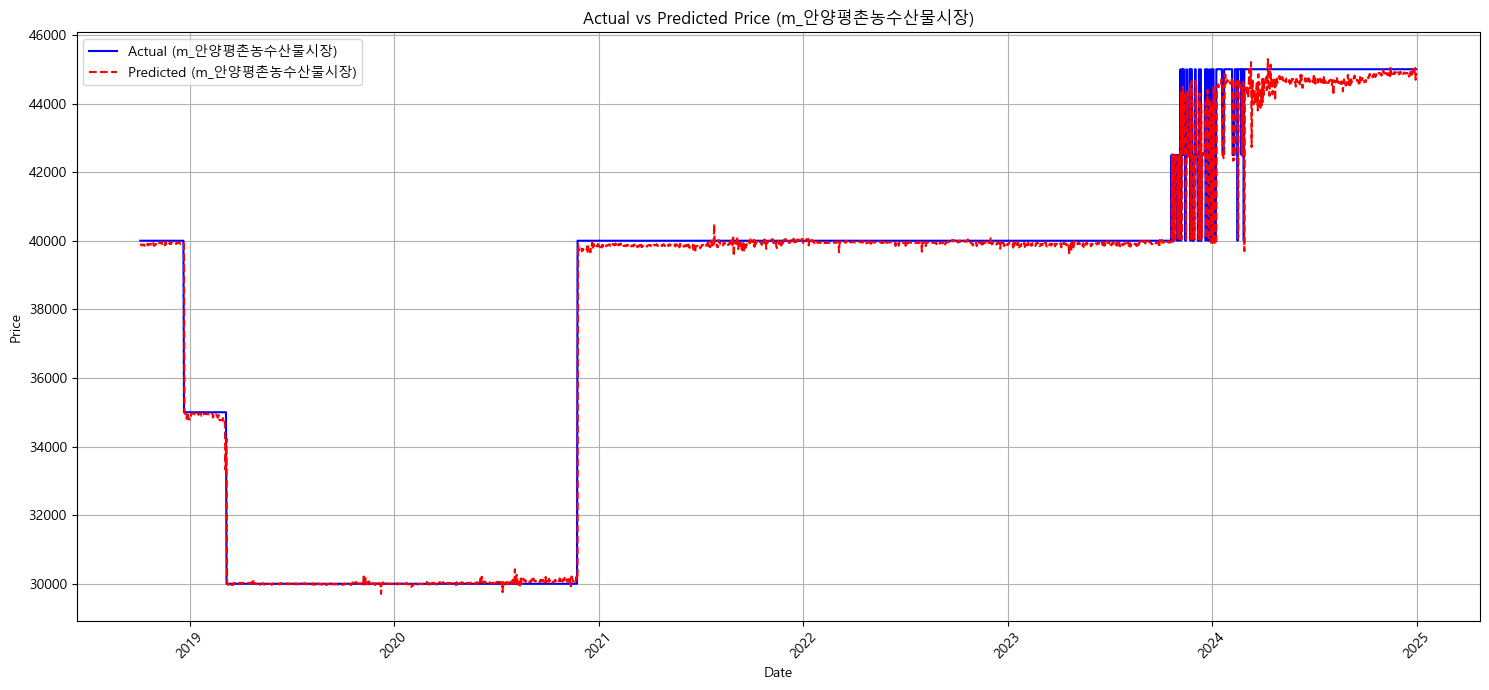

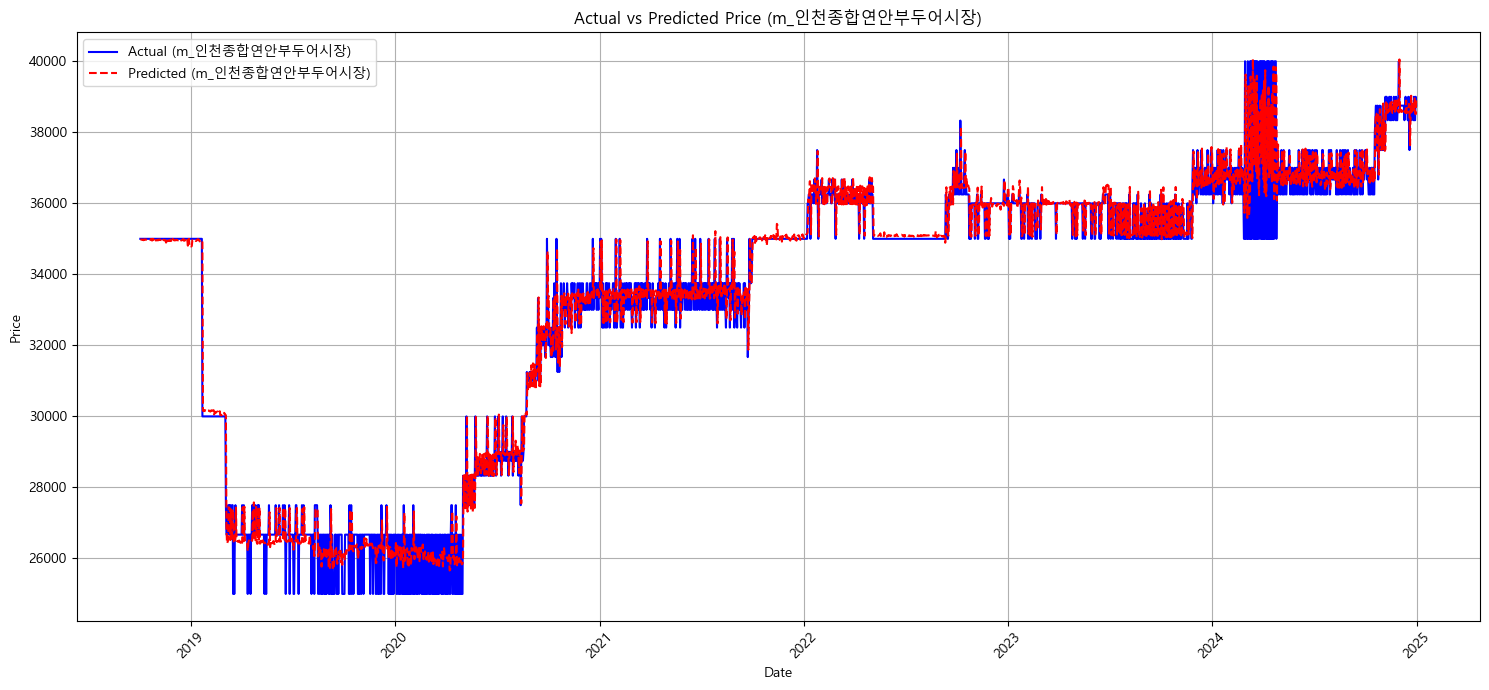


Final Metrics:
MAE: 330.7295
MSE: 502111.7002
RMSE: 708.5984
R2: 0.9794
RMSLE: 0.0193
MAPE: 0.9119
Training_Time: 2.3500

** Market-wise Metrics **
m_가락시장: RMSE = 662.2148, R2 = 0.9810, MAE = 306.5486, MAPE = 0.8071
m_강서농수산물시장: RMSE = 901.4270, R2 = 0.9834, MAE = 531.6881, MAPE = 1.3190
m_구리농수산물시장: RMSE = 880.6801, R2 = 0.8811, MAE = 372.5995, MAPE = 0.9768
m_노량진시장: RMSE = 621.7090, R2 = 0.9627, MAE = 274.1173, MAPE = 0.8133
m_마포농수산물시장: RMSE = 302.1864, R2 = 0.9939, MAE = 127.2674, MAPE = 0.3387
m_부산민락어민활어직판장: RMSE = 456.7374, R2 = 0.9693, MAE = 206.7998, MAPE = 0.6018
m_소래포구종합어시장: RMSE = 914.0856, R2 = 0.9446, MAE = 529.1409, MAPE = 1.5341
m_수원농수산물시장: RMSE = 721.2626, R2 = 0.9773, MAE = 258.0829, MAPE = 0.6926
m_안양평촌농수산물시장: RMSE = 605.0627, R2 = 0.9870, MAE = 196.3357, MAPE = 0.4769
m_인천종합연안부두어시장: RMSE = 817.2820, R2 = 0.9573, MAE = 513.7049, MAPE = 1.5946

Feature Importance:
             Feature  Importance
2     avgPrice_lag_1         559
16          광어_WTI_1         121
13       

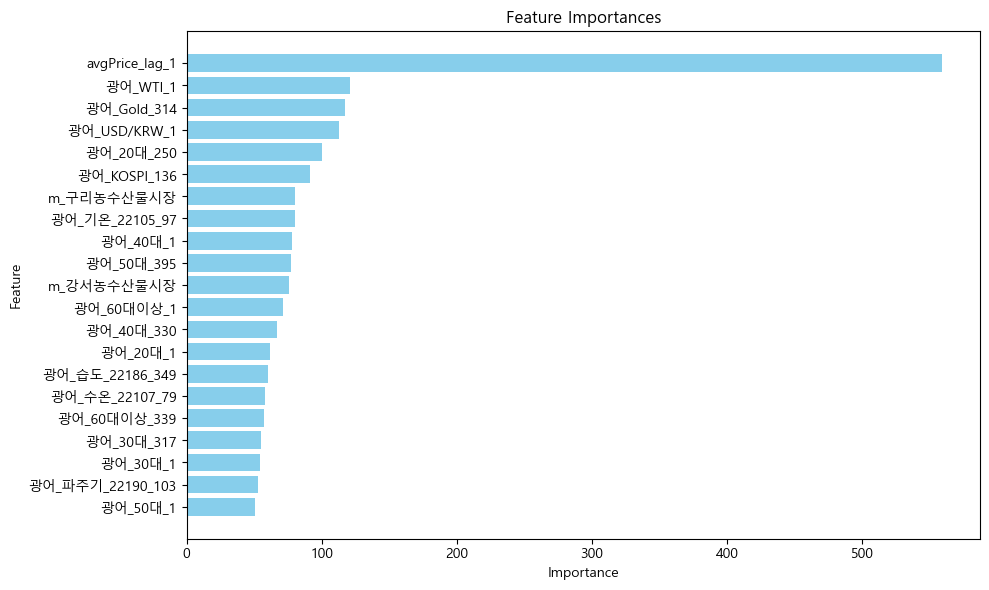

LGBMRegressor(colsample_bytree=0.9, max_depth=8, min_child_samples=7,
              n_estimators=260, n_jobs=-1, num_leaves=9, random_state=1030,
              subsample=0.9)

학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.


In [64]:
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv')
exclude_features = [
     '광어_Silver_238' ,
       '광어_MOVE_18' ,
       '광어_VIX_399' ,
   # '광어_수온_22107_79' ,
        #'광어_40대_330' ,
       #  '광어_60대이상_1' ,
#   '광어_파주기_22190_103' ,
      #'광어_60대이상_339' ,
       #   '광어_50대_1' ,
      #  '광어_30대_317' ,
     'm_인천종합연안부두어시장' ,
       'm_소래포구종합어시장' ,
           'm_노량진시장' ,
     'm_부산민락어민활어직판장' ,
       'm_안양평촌농수산물시장' ,
         'm_수원농수산물시장' ,
             'm_가락시장' ,
        'm_마포농수산물시장' ,
    ]

# exclude_features = ['광어_30대_1']
model_광어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_광어)

# 학습된 모델 저장
joblib.dump(model_광어, 'lgbm_광어.joblib')  

print("\n학습된 모델이 'lgbm_광어.joblib'로 저장되었습니다.")

### 농어

In [94]:

def train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=None, time_series=True):
	"""LightGBM 모델의 그리드서치 수행 및 결과 시각화"""

	# 데이터 전처리
	data['date'] = pd.to_datetime(data['date'])
	X = data.drop(['date', 'item', target_col], axis=1)
	y = data[target_col]

	# 특정 피처 제외
	if exclude_features:
		X = X.drop(columns=exclude_features)

	y = data[target_col]

	# 250127 기준 확정 
	lgbm_params = {
		'n_estimators': [50, 100, 250, 400, 1000],
		'max_depth': [6],
		'learning_rate': [0.1],
		'num_leaves': [8],
		'min_child_samples': [6],
		'subsample': [0.9],
		'colsample_bytree': [0.9],
		'random_state': [1030],
		'n_jobs': [-1]
	}

	# 교차 검증 방식 설정
	if time_series:
		test_size = len(X)//20
		cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
	else:
		cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)


	lgbm = LGBMRegressor(random_state=1030, n_jobs=-1)
	grid_search = GridSearchCV(
		lgbm, lgbm_params,
		cv=cv,
		scoring='neg_root_mean_squared_error',
		n_jobs=-1,
		verbose=1
	)

	# 모델 학습
	start_time = time.time()
	grid_search.fit(X, y)
	training_time = time.time() - start_time

	# 학습 시 사용된 피처 이름 저장
	feature_names = X.columns.tolist()
	joblib.dump(feature_names, 'feature_names.pkl')

	# 결과 출력
	print(training_time)
	print("\n** Model Performance **")
	print(f"Best RMSE: {-grid_search.best_score_:.4f}")
	print("\nBest Parameters:")
	for param, value in grid_search.best_params_.items():
		print(f"{param}: {value}")

	# 예측 및 시각화
	y_pred = grid_search.predict(X)
	plt.figure(figsize=(15, 7))
	plt.plot(data['date'], y, label='Actual', color='blue')
	plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
	plt.title('Actual vs Predicted Price')
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.legend()
	plt.grid(True)
	plt.xticks(rotation=45)
	plt.tight_layout()
	plt.show()

	# 특정 항목별 그래프 생성
	columns_to_filter = [
		"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
		"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
		"m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
	]

	metrics_by_market = {}  # 시장별 성능 저장

	for col in columns_to_filter:
		filtered_data = data[data[col] == 1]
		filtered_y = y[data[col] == 1]
		filtered_y_pred = y_pred[data[col] == 1]

		if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
			# RMSE와 R2 계산
			rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
			r2 = r2_score(filtered_y, filtered_y_pred)
			mae = mean_absolute_error(filtered_y, filtered_y_pred)
			mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
			
			metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

			# 그래프 생성
			plt.figure(figsize=(15, 7))
			plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
			plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
			plt.title(f'Actual vs Predicted Price ({col})')
			plt.xlabel('Date')
			plt.ylabel('Price')
			plt.legend()
			plt.grid(True)
			plt.xticks(rotation=45)								
			plt.tight_layout()
			plt.show()


	# 최종 메트릭 계산 및 출력
	metrics = calculate_metrics(y, y_pred, training_time)
	print("\nFinal Metrics:")
	for k, v in metrics.items():
		print(f"{k}: {v:.4f}")


	# 시장별 성능 출력
	print("\n** Market-wise Metrics **")
	for market, metrics in metrics_by_market.items():
		print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")

	# 중요도 계산 및 시각화 추가
	print("\nFeature Importance:")
	feature_importances = grid_search.best_estimator_.feature_importances_
	feature_names = X.columns
	importance_df = pd.DataFrame({
		'Feature': feature_names,
		'Importance': feature_importances
	}).sort_values(by='Importance', ascending=False)
	print(importance_df)

	# 중요도 시각화
	plt.figure(figsize=(10, 6))
	plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title('Feature Importances')
	plt.gca().invert_yaxis()  # 중요도가 높은 순으로 위에서 아래로 정렬
	plt.tight_layout()
	plt.show()

	return grid_search.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5307
[LightGBM] [Info] Number of data points in the train set: 25023, number of used features: 30
[LightGBM] [Info] Start training from score 36142.972066
6.126516819000244

** Model Performance **
Best RMSE: 1023.2086

Best Parameters:
colsample_bytree: 0.9
learning_rate: 0.1
max_depth: 6
min_child_samples: 6
n_estimators: 100
n_jobs: -1
num_leaves: 8
random_state: 1030
subsample: 0.9


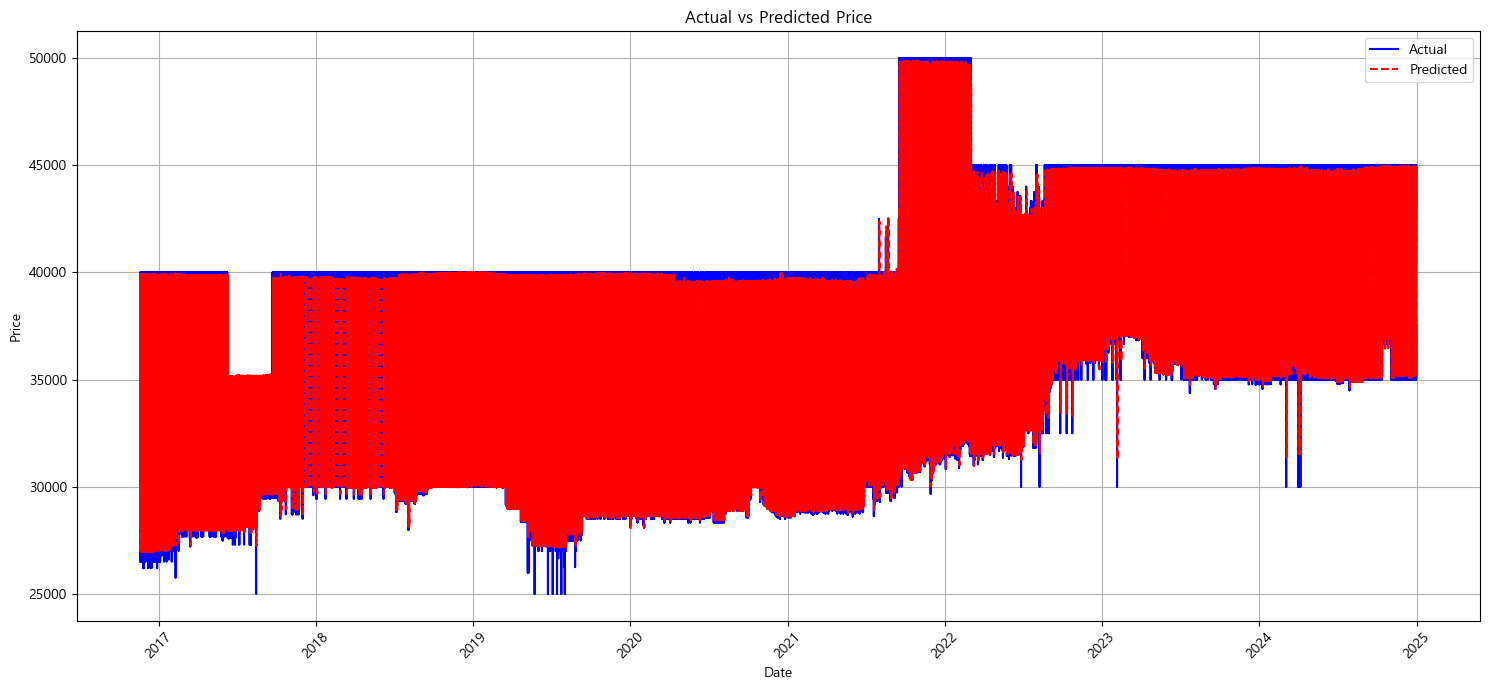

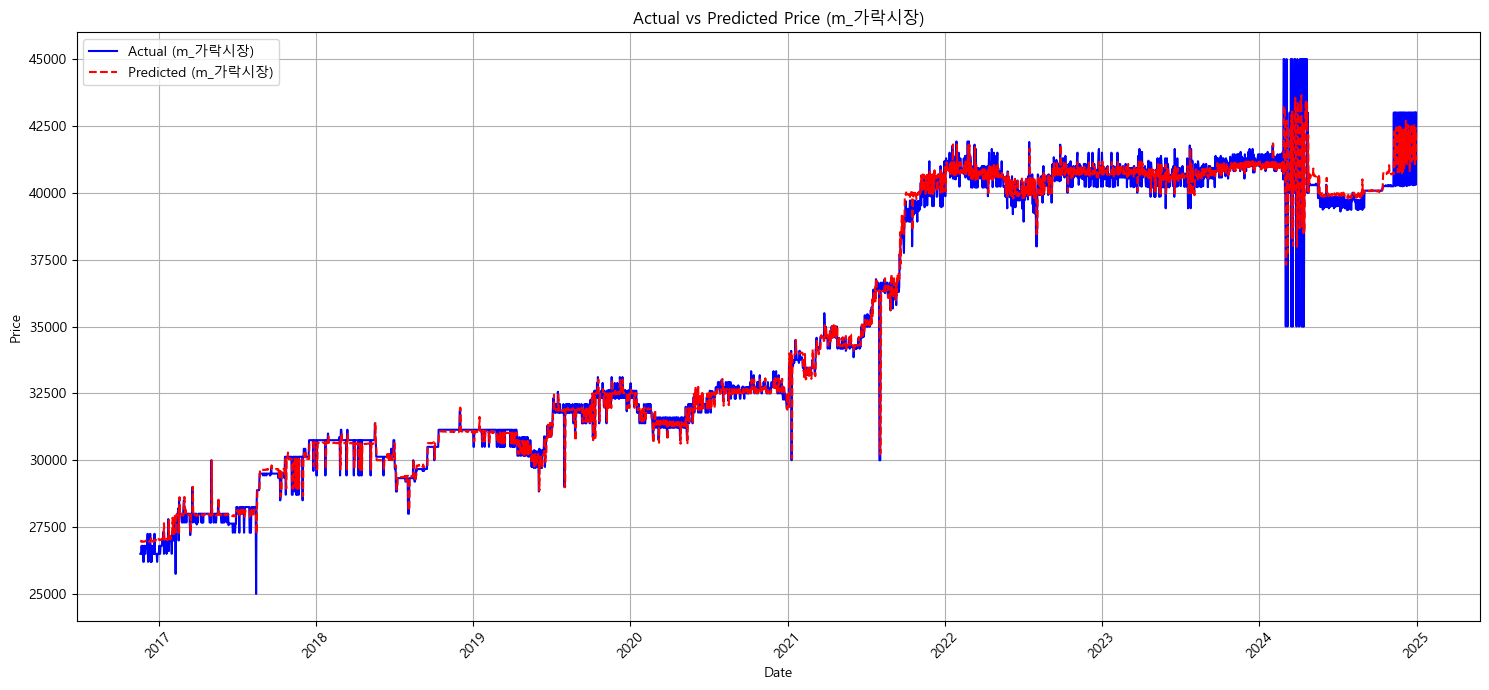

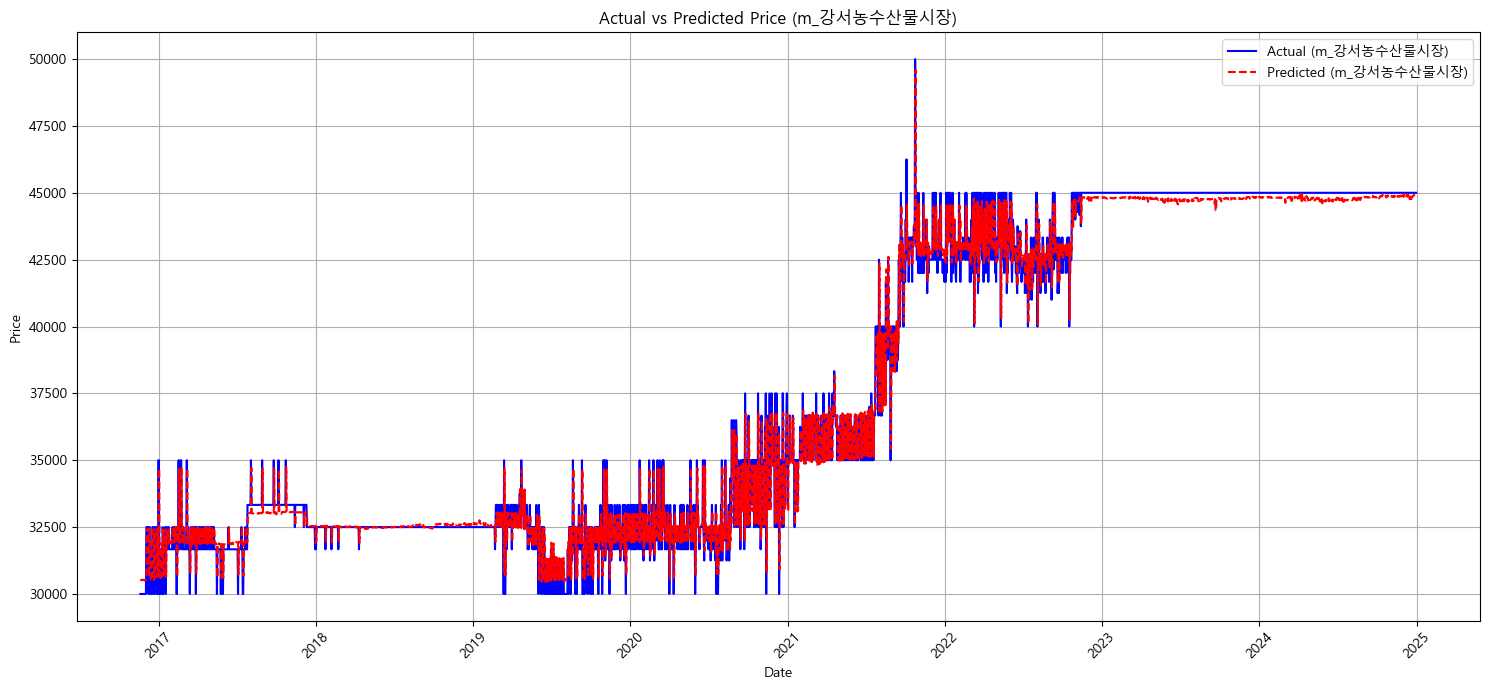

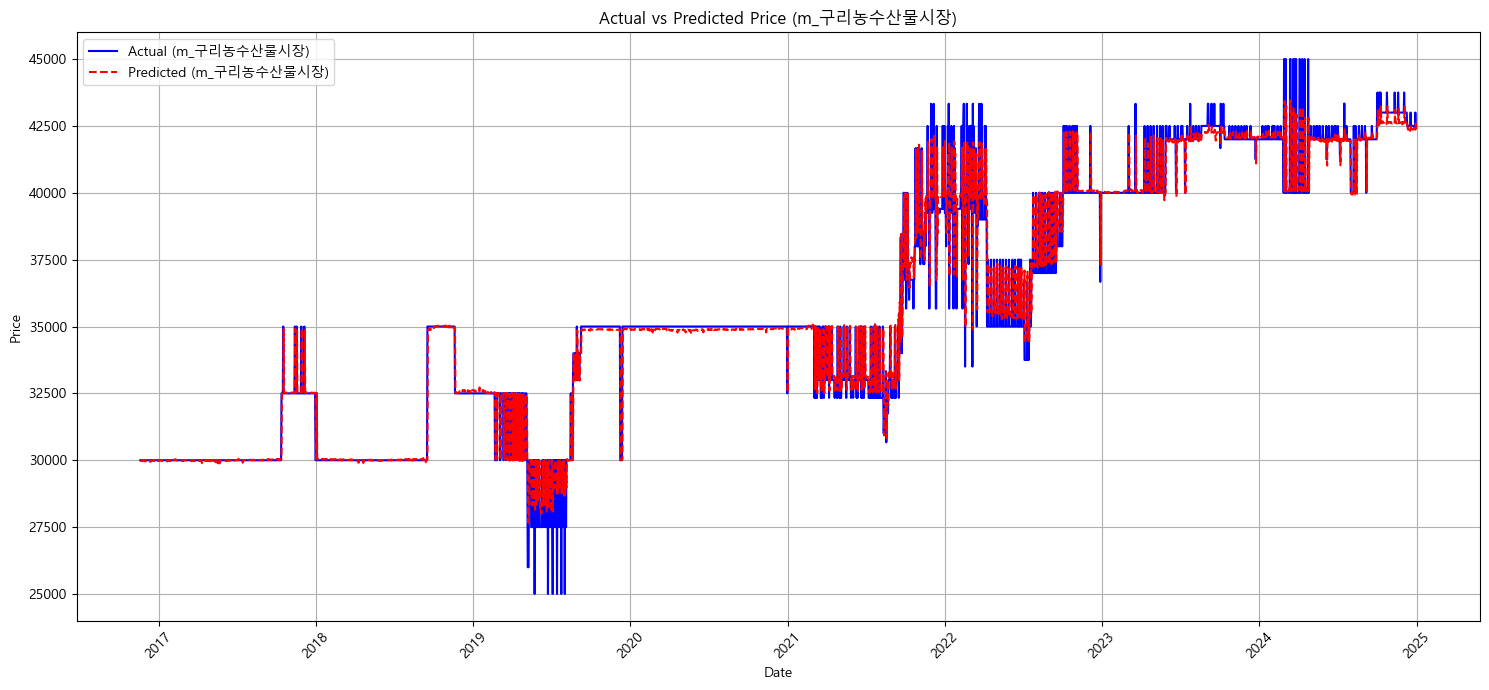

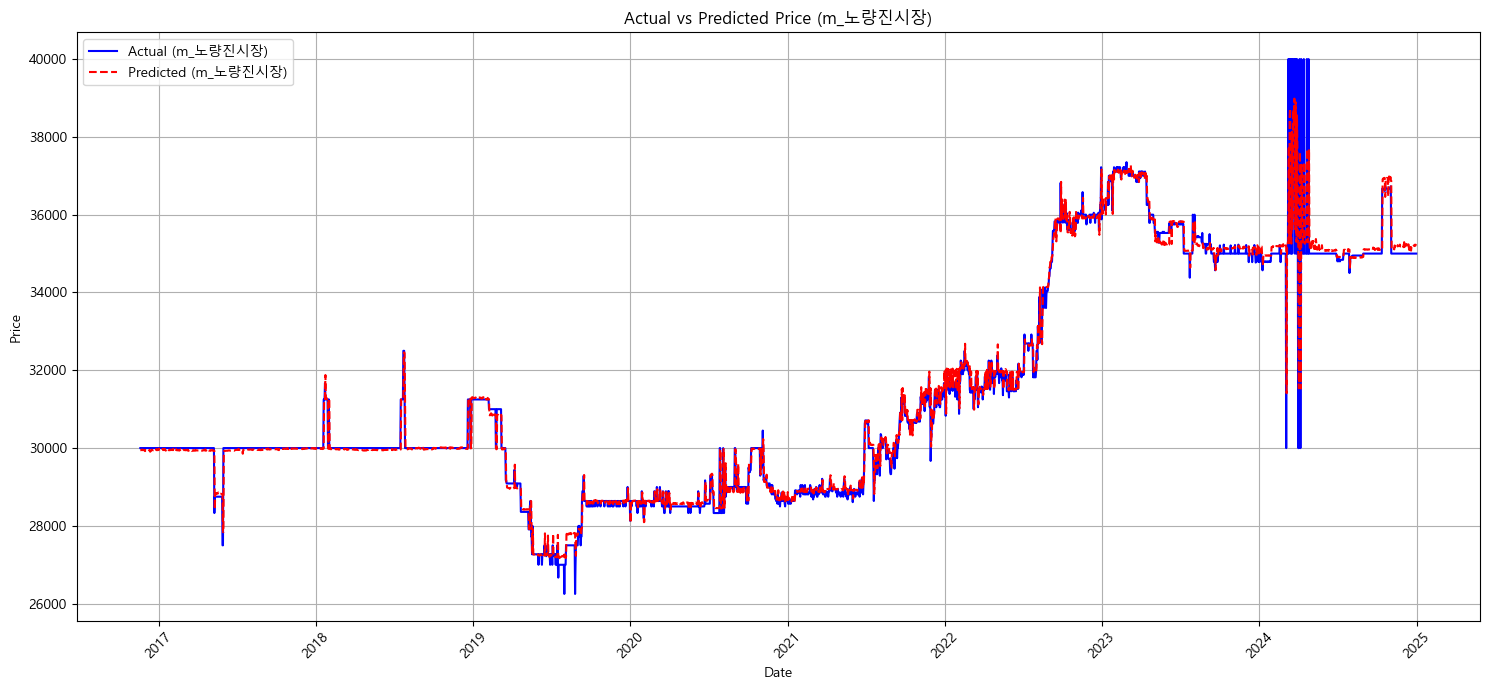

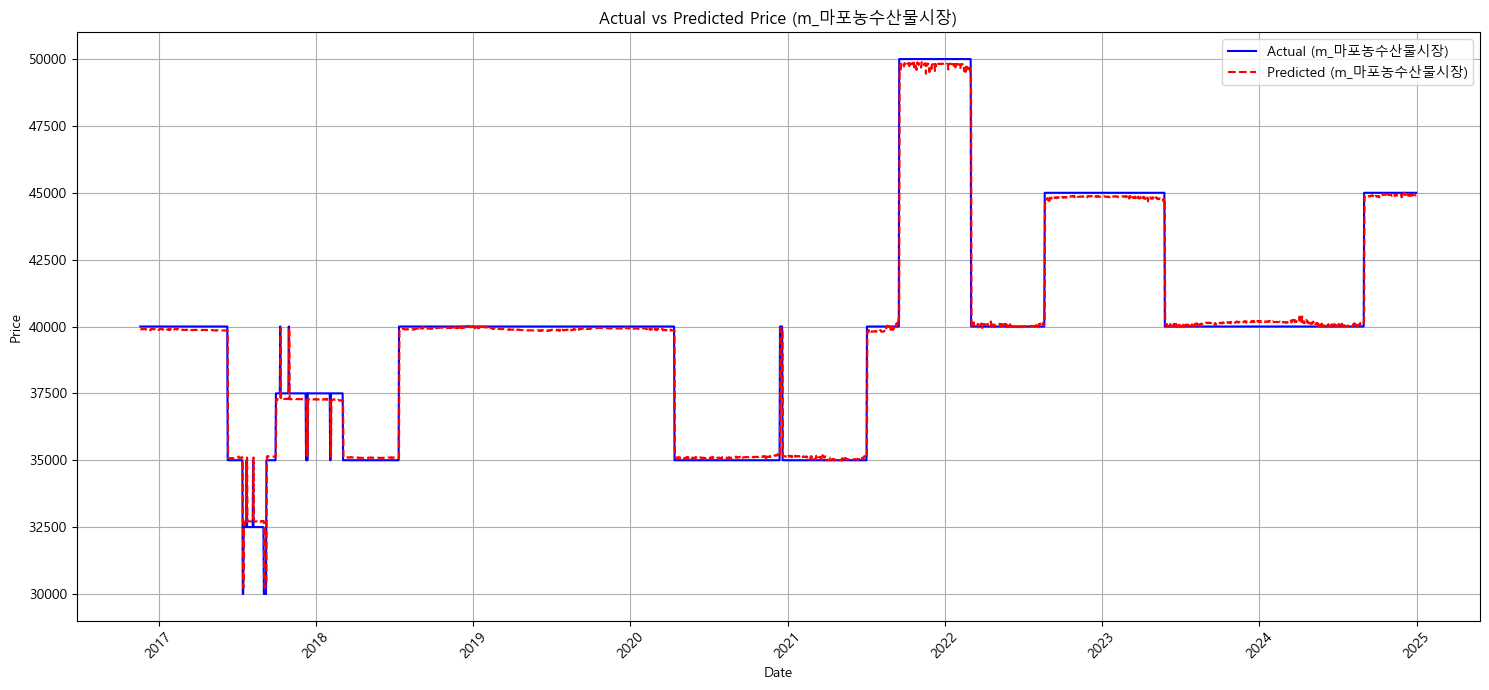

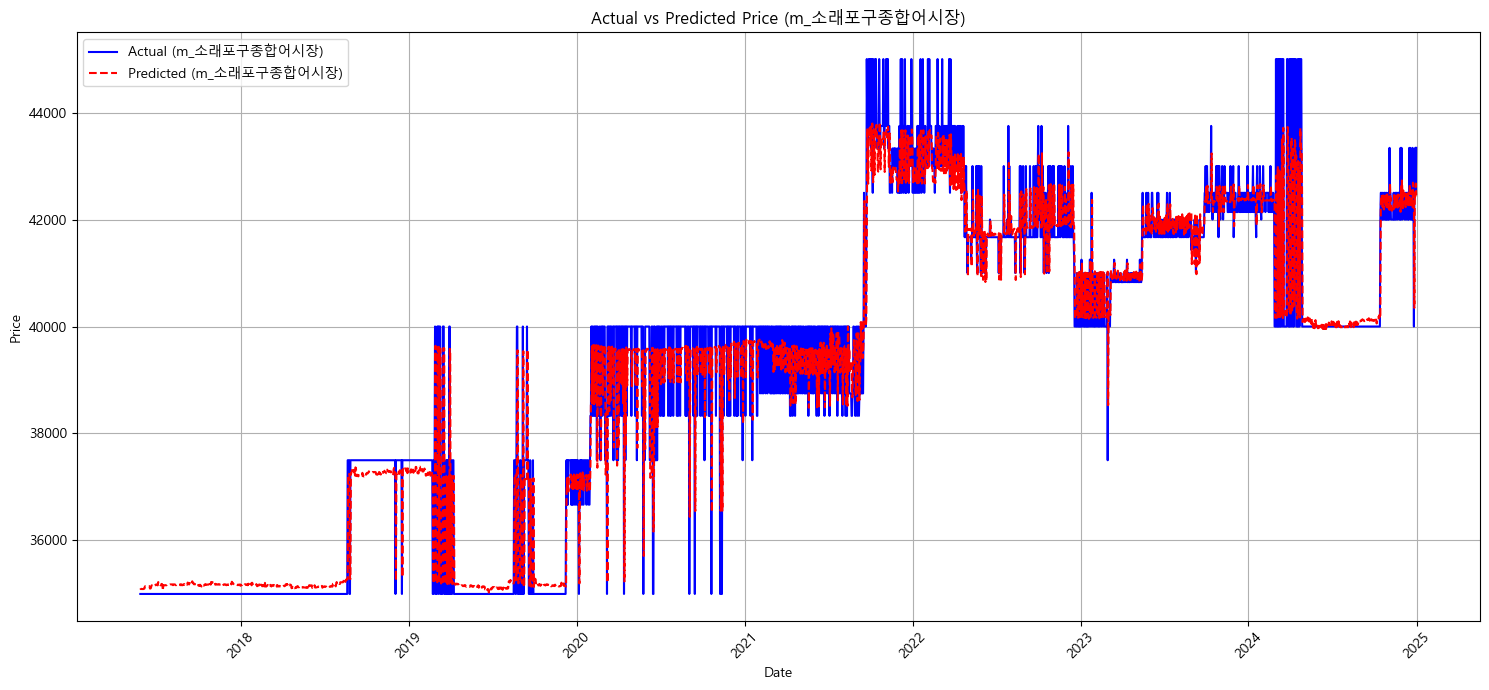

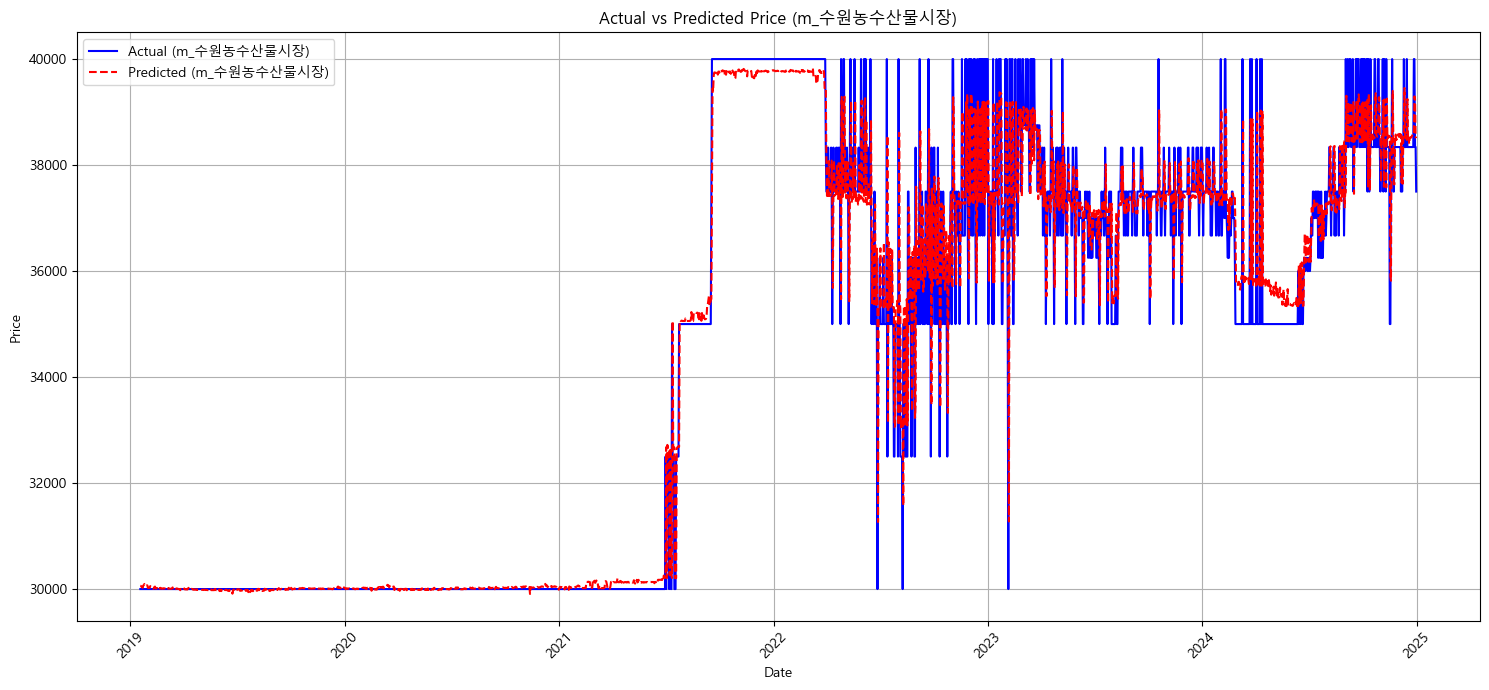

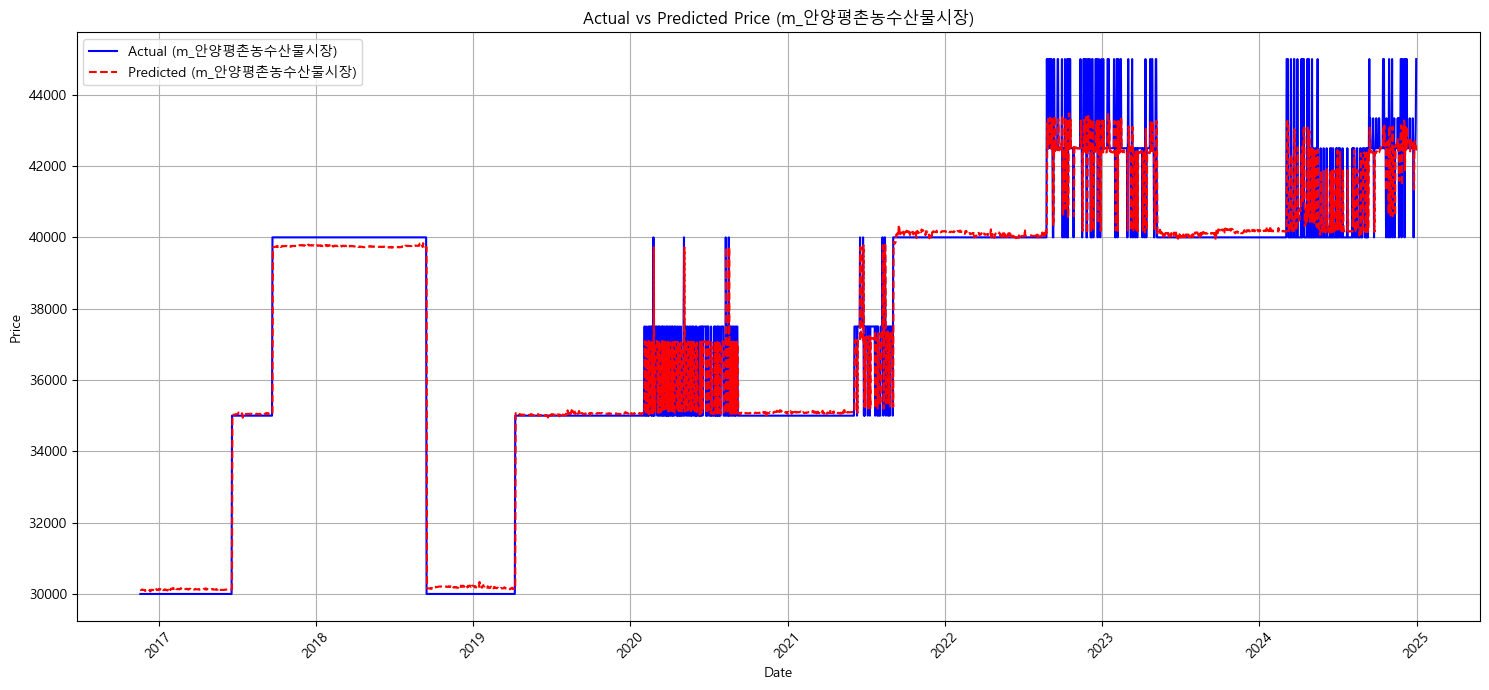

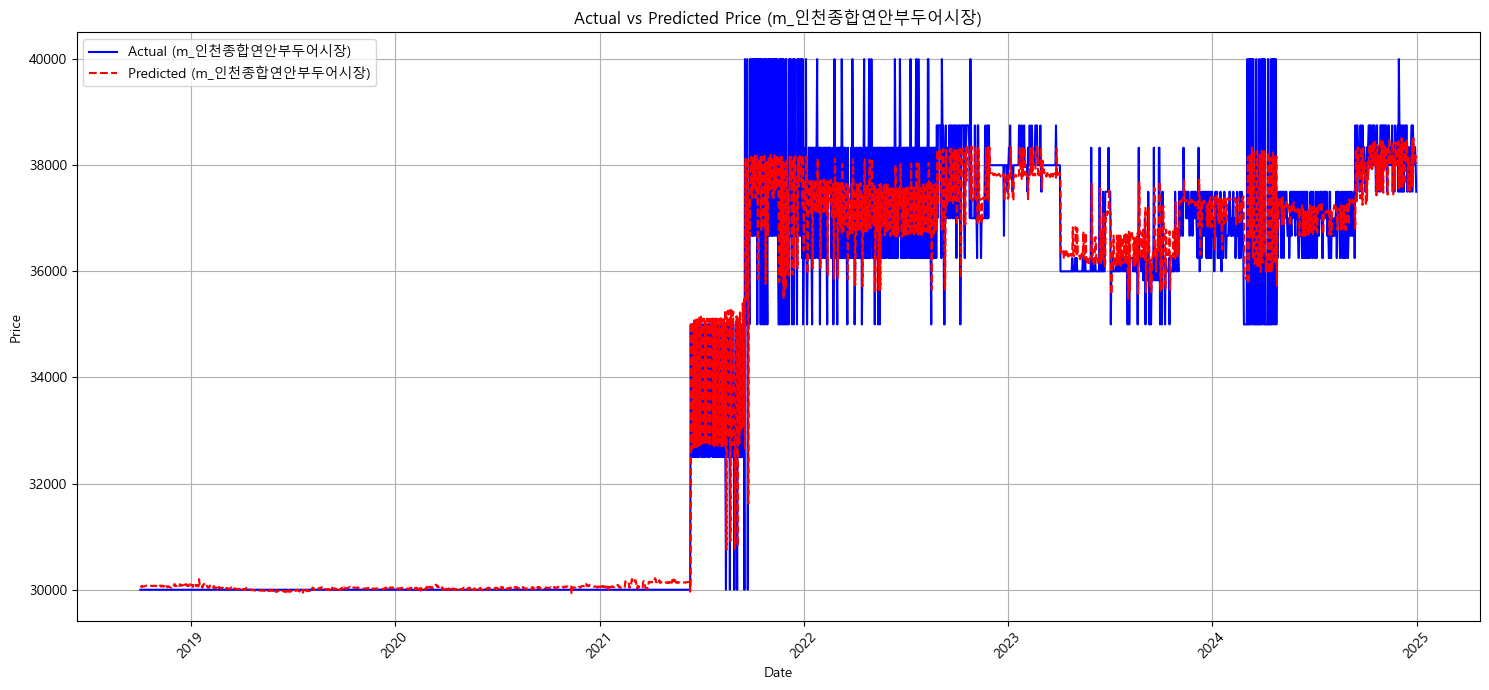


Final Metrics:
MAE: 414.1214
MSE: 716943.8660
RMSE: 846.7254
R2: 0.9707
RMSLE: 0.0229
MAPE: 1.1237
Training_Time: 6.1265

** Market-wise Metrics **
m_가락시장: RMSE = 722.1404, R2 = 0.9791, MAE = 374.4231, MAPE = 1.0485
m_강서농수산물시장: RMSE = 1000.8117, R2 = 0.9697, MAE = 610.3858, MAPE = 1.6883
m_구리농수산물시장: RMSE = 1031.2630, R2 = 0.9496, MAE = 479.1295, MAPE = 1.3361
m_노량진시장: RMSE = 448.0829, R2 = 0.9759, MAE = 172.0451, MAPE = 0.5294
m_마포농수산물시장: RMSE = 446.1299, R2 = 0.9874, MAE = 157.1074, MAPE = 0.3981
m_소래포구종합어시장: RMSE = 882.2404, R2 = 0.9113, MAE = 503.4066, MAPE = 1.2696
m_수원농수산물시장: RMSE = 944.0297, R2 = 0.9424, MAE = 483.2368, MAPE = 1.3214
m_안양평촌농수산물시장: RMSE = 906.4046, R2 = 0.9497, MAE = 425.6386, MAPE = 1.0910
m_인천종합연안부두어시장: RMSE = 1057.1629, R2 = 0.9176, MAE = 585.2453, MAPE = 1.6036

Feature Importance:
             Feature  Importance
10    avgPrice_lag_1         285
20       농어_Gold_361          45
21      농어_KOSPI_179          28
24      농어_USD/KRW_1          27
26        농어_WT

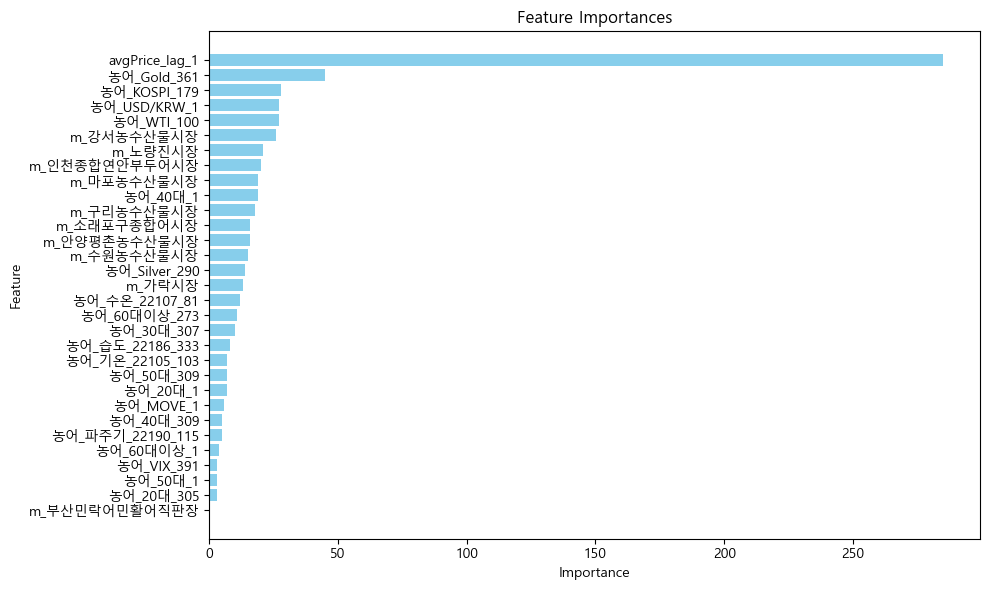

LGBMRegressor(colsample_bytree=0.9, max_depth=6, min_child_samples=6, n_jobs=-1,
              num_leaves=8, random_state=1030, subsample=0.9)

학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.


In [95]:
data = pd.read_csv('../../../data/features/final_oneHot/농어_price_features_notnull.csv')
exclude_features = [
#      '광어_Silver_238' ,
#        '광어_MOVE_18' ,
#        '광어_VIX_399' ,
#    # '광어_수온_22107_79' ,
#         #'광어_40대_330' ,
#        #  '광어_60대이상_1' ,
# #   '광어_파주기_22190_103' ,
#       #'광어_60대이상_339' ,
#        #   '광어_50대_1' ,
#       #  '광어_30대_317' ,
#      'm_인천종합연안부두어시장' ,
#        'm_소래포구종합어시장' ,
#            'm_노량진시장' ,
#      'm_부산민락어민활어직판장' ,
#        'm_안양평촌농수산물시장' ,
#          'm_수원농수산물시장' ,
#              'm_가락시장' ,
#         'm_마포농수산물시장' ,
    ]

exclude_features = ['농어_30대_1']
model_농어 = train_evaluate_lgbm(data, target_col='avgPrice', exclude_features=exclude_features, time_series=True)

print(model_농어)

# 학습된 모델 저장
joblib.dump(model_농어, 'lgbm_농어.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장

print("\n학습된 모델이 'lgbm_농어.joblib'로 저장되었습니다.")

### 기타

#### 가격 예측 

In [ ]:
# 저장된 모델 로드
loaded_model = joblib.load('xgb_광어.joblib')
print("모델이 성공적으로 로드되었습니다.")

모델이 성공적으로 로드되었습니다.


In [ ]:
# 저장된 모델 및 피처 이름 로드
loaded_model = joblib.load('xgb_광어.joblib')
feature_names = joblib.load('feature_names.pkl')

# 예측 데이터 준비
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_notnull.csv') 
X = data[feature_names]  # 학습 시 사용된 피처만 선택

# 결과 저장용 리스트
market_predictions = []

# 시장별 예측
markets = [
	"m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진시장",
	"m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장",
	"m_수원농수산물시장", "m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
]

for market in markets:
	# 시장별 데이터 필터링
	market_data = data[data[market] == 1]

	if not market_data.empty:  # 데이터가 존재할 경우에만 실행
		X = market_data[feature_names]  # 학습 시 사용된 피처만 선택
		y_pred = loaded_model.predict(X)  # 시장별 예측

		# 다음날 날짜 생성
		last_date = pd.to_datetime(market_data['date'].iloc[-1])  # 마지막 날짜
		next_date = last_date + pd.Timedelta(days=1)

		# 결과 저장
		market_predictions.append({
			'Market': market,
			'Next_Date': next_date.strftime('%Y-%m-%d'),
			'Predicted_Price': y_pred[-1]  # 가장 마지막 예측 값 (다음날 예측)
		})

# 결과 데이터프레임 생성
result_df = pd.DataFrame(market_predictions)

# 결과 출력
print("시장별 내일 가격 예측:")
print(result_df)

# # 결과 저장
# result_df.to_csv('market_predictions.csv', index=False)
# print("시장별 예측 결과가 'market_predictions.csv'에 저장되었습니다.")


시장별 내일 가격 예측:
          Market   Next_Date  Predicted_Price
0         m_가락시장  2025-01-01     44670.269531
1     m_강서농수산물시장  2025-01-01     47503.644531
2     m_구리농수산물시장  2025-01-01     40043.246094
3        m_노량진시장  2025-01-01     39562.347656
4     m_마포농수산물시장  2025-01-01     44670.269531
5  m_부산민락어민활어직판장  2025-01-01     40129.937500
6    m_소래포구종합어시장  2025-01-01     41195.082031
7     m_수원농수산물시장  2025-01-01     42062.718750
8   m_안양평촌농수산물시장  2025-01-01     44670.269531
9  m_인천종합연안부두어시장  2025-01-01     38734.714844
